# Mixture of Compound Gaussians - MNIST experiments 

Compound Gaussian is a more general class of distributions that can be expressed as

$$X = \mu + \sqrt{\tau} A g$$

with $\tau \geq 0$ random variable, $g\sim \mathcal{N}(0, I)$, $AA^T=\Sigma$ 

$X_i|\tau=\tau_i \sim \mathcal{N}(\mu_j,\tau_i \Sigma_j)$

We load the libraries

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math
from scipy.stats import t
from scipy.stats import multivariate_normal
from scipy.special import gamma

# PLOT:
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import spectral_clustering
from sklearn.manifold import TSNE
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA

# EMBEDDINGs:
import umap

import hdbscan

In [2]:
from frem import *
from import_subset_datasets import *
from clustering_accuracy import *

In [3]:
warnings.filterwarnings('ignore') # AMI warning

# MNIST 

### Import pairs [3, 8] and [7, 1]

In [4]:
np.random.seed(44)
random.seed(44)

read_mnist = pd.read_csv(r"data\mnist_train.csv")

mnist_labels_raw = read_mnist.iloc[:, 0]

mnist_data = read_mnist.iloc[:, 1:]

selected_digits = [3, 8]
selected_digits_2 = [7, 1]

mnist_pca, mnist_labels, mnist_raw, ve = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [ ]:
np.savetxt("mnist_pca.csv", mnist_pca, delimiter=",") # to run in R
np.savetxt("mnist_pca_2.csv", mnist_pca_2, delimiter=",") # to run in R
np.savetxt("mnist_labels.csv", mnist_labels, delimiter=",") # to run in R

### Plot digits

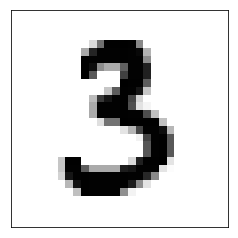

In [5]:
plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow((mnist_raw.iloc[0, :].values).reshape((28,28)), cmap="binary")

## Data 1: MNIST 3-8

### UMAP embedding

In [6]:
embedding = umap.UMAP(metric='euclidean').fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_real.png",dpi =300)

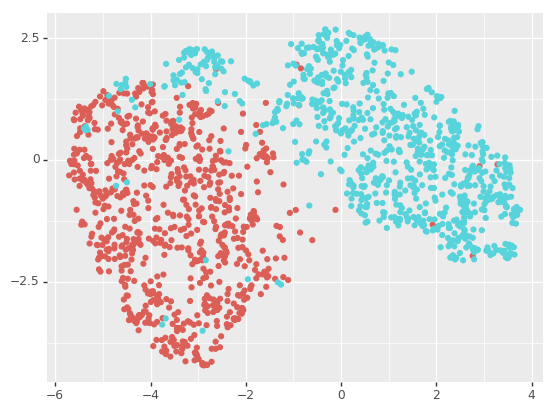

<ggplot: (146029554005)>

In [7]:
gg

### K-means

In [8]:
nrep = 100
kmeans_AMI = np.zeros((nrep, ))
kmeans_ARI = np.zeros((nrep, ))

for rep in range(nrep):

    kmeans = KMeans(n_clusters=2).fit(mnist_pca)
    kmeans_ARI[rep] = metrics.adjusted_rand_score(label, kmeans.labels_.astype(str))
    kmeans_AMI[rep] = metrics.adjusted_mutual_info_score(label, kmeans.labels_.astype(str))
    
print(np.median(kmeans_AMI))
print(np.median(kmeans_ARI))
print(np.min(kmeans_AMI))
print(np.min(kmeans_ARI))
print(np.max(kmeans_AMI))
print(np.max(kmeans_ARI))
print(np.std(kmeans_AMI))
print(np.std(kmeans_ARI))

0.22035537906072133
0.2884626071030122
0.2162776801526364
0.2831096646451016
0.22035537906072133
0.2884626071030122
0.0005399633831741651
0.0007014703435541333


In [9]:
em = pd.DataFrame(embedding, columns=['A','B']) 
em['kmeans'] = kmeans.labels_.astype(str)
gg = ggplot(aes(x='A', y='B', color='kmeans'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_kmeans.png",dpi =300)

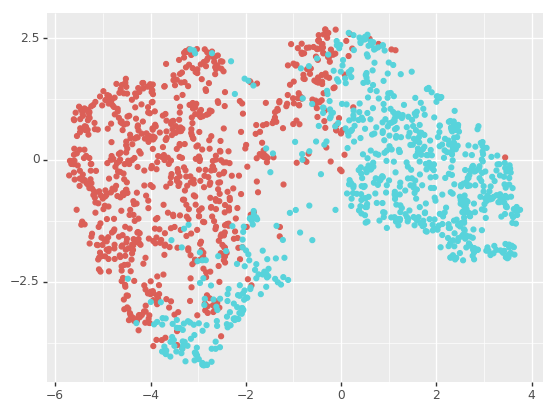

<ggplot: (-9223371890823460110)>

In [10]:
gg

In [11]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, kmeans.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, kmeans.labels_.astype(str)))
print('ACC: ', acc(label.astype(int), kmeans.labels_.astype(int)))

AMI:  0.22035537906072133
ARI:  0.2884626071030122
ACC:  0.76875


### GMM-EM

In [12]:
nrep = 100
gmm_AMI = np.zeros((nrep, ))
gmm_ARI = np.zeros((nrep, ))

for rep in range(nrep):

    gmm = GaussianMixture(n_components=2).fit(mnist_pca)
    labels_gmm = gmm.predict(mnist_pca)
    gmm_ARI[rep] = metrics.adjusted_rand_score(label, labels_gmm.astype(str))
    gmm_AMI[rep] = metrics.adjusted_mutual_info_score(label, labels_gmm.astype(str))
    
print(np.median(gmm_AMI))
print(np.median(gmm_ARI))
print(np.quantile(gmm_AMI, 0.25))
print(np.quantile(gmm_ARI, 0.25))
print(np.quantile(gmm_AMI, 0.75))
print(np.quantile(gmm_ARI, 0.75))
print(np.std(gmm_AMI))
print(np.std(gmm_ARI))  

0.4878455512478535
0.5716519073226696
0.4878455512478535
0.5716519073226696
0.5141729329339585
0.6003796358455173
0.012753923141468159
0.013795923462525174


In [13]:
em = pd.DataFrame(embedding, columns=['A','B']) 
em['gmm'] = labels_gmm.astype(str)
gg = ggplot(aes(x='A', y='B', color='gmm'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_GMM.png",dpi =300)

In [14]:
print('ACU: ', acc(label.astype(int), labels_gmm.astype(int)))
print('AMI: ', metrics.adjusted_mutual_info_score(labels_gmm, mnist_labels))
print('ARI: ', metrics.adjusted_rand_score(labels_gmm, mnist_labels))

ACU:  0.878125


### FREM

In [15]:
nrep = 10
frem_AMI = np.zeros((nrep, ))
frem_ARI = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(2, mnist_pca, 200, False, 2, 25)  
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI))
print(np.median(frem_ARI))
print(np.quantile(frem_AMI, 0.25))
print(np.quantile(frem_ARI, 0.25))
print(np.quantile(frem_AMI, 0.75))
print(np.quantile(frem_ARI, 0.75))

ite:  0
ite:  10
ite:  20
ite:  30
ite:  40
ite:  50
ite:  60
convergence:  True
number of iterations:  68
0.5949424916598424
0.6887069859204329
0.5949424916598424
0.6887069859204329
0.5949424916598424
0.6887069859204329


In [17]:
em['frem'] = labels_frem.astype(str)
gg = ggplot(aes(x='A', y='B', color='frem'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_frem.png",dpi =300)

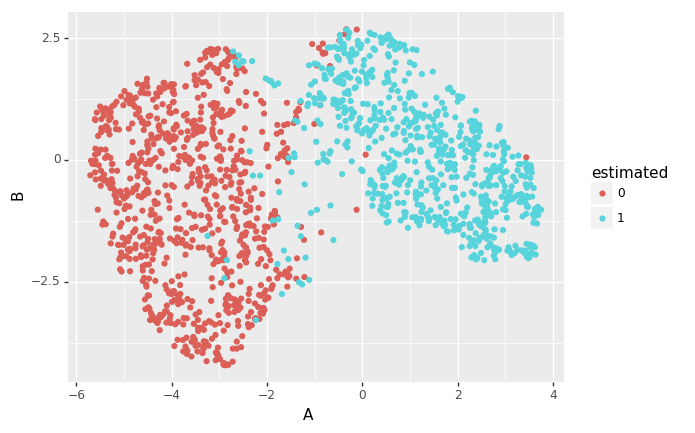

<ggplot: (146031320924)>

In [18]:
cond_prob = compute_condition_prob_matrix(mnist_pca, theta_estimated_1)
labels_cg = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated')) + geom_point()

In [19]:
print('AMI: ', metrics.adjusted_mutual_info_score(labels_cg, mnist_labels))
print('ARI: ', metrics.adjusted_rand_score(labels_cg, mnist_labels))
print('ACU: ', acc(label.astype(int), labels_frem.astype(int)))

AMI:  0.5949424916598425
ARI:  0.6887069859204329
ACU:  0.915


### t-EM from R EMMIX

In [ ]:
rlabels = pd.read_csv("labels_frem_MNIST.csv").values[:,0]

In [ ]:
rlabels

In [ ]:
em['tem'] = rlabels.astype(str)
gg = ggplot(aes(x='A', y='B', color='tem'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_tem.png",dpi =300)

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels, rlabels))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels, rlabels))

In [ ]:
print('ACU: ', acc(mnist_labels, rlabels))

### HDBSCAN

In [ ]:
rrr = [5, 10, 15, 20, 25, 30, 35, 40 ,45, 50, 55, 60, 65, 70, 75, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500,  550, 600, 650, 700]
rrr2 = [1, 2, 3, 4,5, 10, 15, 20, 30, 40 ,50, 70, 80, 100]
maxim = 0
i_maxim = 0
ite = 0
for param1 in rrr:
    for param2 in rrr2:
        ite += 1
        print(ite)
        print(maxim, param1, param2)
        hdbis = hdbscan.HDBSCAN(min_cluster_size=param1, min_samples= param2)
        hdbis.fit(mnist_pca)
        em['hdbs'] = hdbis.labels_.astype(str)
        print("param1:", param1, "param2:", param2)
        print('AMI: ', metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)))
        print('ARI: ', metrics.adjusted_rand_score(label, hdbis.labels_.astype(str)))
        if (metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)) > maxim):
            i_maxim = ite
            maxim = metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str))

In [ ]:
i_maxim

In [ ]:
# same colors
from mizani.palettes import (hue_pal, brewer_pal, grey_pal,
                             gradient_n_pal, cmap_pal, cmap_d_pal,
                             desaturate_pal)
hue_pal(h=.01, l=.6, s=.65, color_space='hls')(2)

In [ ]:
hdbis = hdbscan.HDBSCAN(min_cluster_size=5, min_samples = 15)
hdbis.fit(mnist_pca)
em['hdbs'] = hdbis.labels_.astype(str)
print("param1:", param1, "param2:", param2)
print(hdbis.labels_)
print('AMI: ', metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, hdbis.labels_.astype(str)))
if (metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str)) > maxim):
    i_maxim = ite
    maxim = metrics.adjusted_mutual_info_score(label, hdbis.labels_.astype(str))

gg = ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+scale_color_manual(["black","#db5f57", "#57d3db"], guide = False) + xlab("")+ylab("")
gg.save("MNIST38_hdbscan.png",dpi =300)

In [ ]:
i_maxim

In [ ]:
hdbis = hdbscan.HDBSCAN(min_cluster_size=3, min_samples= 3)
hdbis.fit(embedding)
em['hdbs'] = hdbis.labels_.astype(str)
print(ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+ scale_color_discrete(guide=False) +xlab("")+ylab(""))

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(label,hdbis.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, hdbis.labels_.astype(str)))

### Spectral

In [20]:
spectral = SpectralClustering(n_clusters = 2, affinity= "nearest_neighbors", n_neighbors=5)
spectral.fit(mnist_pca)
print(spectral.labels_)
print('AMI: ', metrics.adjusted_mutual_info_score(label, spectral.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, spectral.labels_.astype(str)))

[0 0 0 ... 1 1 1]
AMI:  0.5805530206196403
ARI:  0.6518435798264998


In [ ]:
plt.plot(silu)
plt.show()

In [21]:
em['spectral'] = spectral.labels_.astype(str)
gg = ggplot(aes(x='A', y='B', color='spectral'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
gg.save("MNIST38_spectral.png",dpi =300)

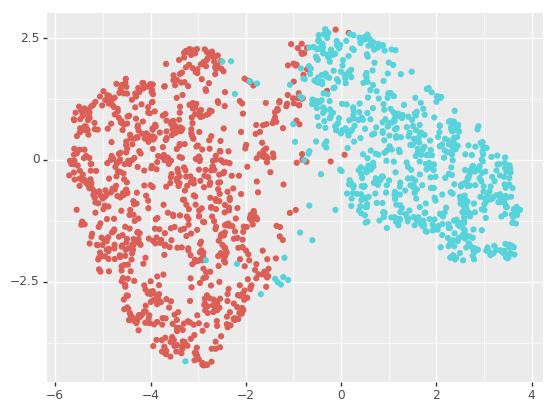

<ggplot: (-9223371890692769020)>

In [22]:
gg

In [ ]:
print('ACU: ', acc(mnist_labels, spectral.labels_.astype(int)))

## Data 2: MNIST 7-1

### UMAP

In [ ]:
embedding2 = umap.UMAP(n_neighbors=10, min_dist=0.001,
                      metric='euclidean').fit_transform(mnist_pca_2)

label = pd.Series(mnist_labels_2)
em2 = pd.DataFrame(embedding2, columns=['A','B']) 
em2['label'] = label.astype(str)
ggplot(aes(x='A', y='B', color='label'), data=em2)+geom_point()+ scale_color_discrete(guide=False)

### Kmeans

In [ ]:
kmeans = KMeans(n_clusters=2).fit(mnist_pca_2)
em2['kmeans'] = pd.Series(kmeans.labels_.astype(str))
em2['label'] = pd.Series(mnist_labels_2)
ggplot(em2, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_2, kmeans.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, kmeans.labels_.astype(str)))
print('ACC: ', acc(mnist_labels_2.astype(int), kmeans.labels_.astype(int)))

### GMM

In [ ]:
gmm = GaussianMixture(n_components=2).fit(mnist_pca_2)
labels_gmm_2 = gmm.predict(mnist_pca_2)
em2['gmm'] = pd.Series(labels_gmm_2.astype(str))
ggplot(em2, aes(x='A',y='B',color='gmm'))+geom_point()+ylab("")+xlab("")

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_2, labels_gmm_2))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, labels_gmm_2))
print('ACC: ', acc(mnist_labels_2.astype(int), labels_gmm_2.astype(int)))

### Robust EM

In [ ]:
nrep = 1
frem_AMI_2 = np.zeros((nrep, ))
frem_ARI_2 = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(2, mnist_pca_2, 150, False, 4, 30) 
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_2[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_2[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))


In [ ]:
print(np.median(frem_AMI_2))
print(np.median(frem_ARI_2))
print(np.quantile(frem_AMI_2, 0.25))
print(np.quantile(frem_ARI_2, 0.25))
print(np.quantile(frem_AMI_2, 0.75))
print(np.quantile(frem_ARI_2, 0.75))

In [ ]:
cond_prob_2 = compute_condition_prob_matrix(mnist_pca_2, theta_estimated_1)
labels_cg_2 = np.array([i for i in np.argmax(cond_prob_2, axis=1)])
em2['cg'] = pd.Series(labels_cg_2.astype(str))
ggplot(em2, aes(x='A',y='B',color='cg'))+geom_point()

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score( mnist_labels_2, labels_cg_2))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, labels_cg_2))
print('ACU: ', acc(mnist_labels_2.astype(int), labels_frem.astype(int)))

### t-EM from R

In [ ]:
rlabels = pd.read_csv("labels_frem_MNIST_2.csv").values[:,0]
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_2, rlabels))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, rlabels))
print('ACU: ', acc(mnist_labels_2.astype(int), rlabels))

### spectral

In [ ]:
spectral = SpectralClustering(n_clusters = 2, affinity= "nearest_neighbors", n_neighbors=5)
spectral.fit(mnist_pca_2)
print('AMI: ', metrics.adjusted_mutual_info_score(label, spectral.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, spectral.labels_.astype(str)))
print('ACU: ', acc(mnist_labels_2.astype(int), spectral.labels_.astype(int)))

## MNIST -  [3, 8, 6]

In [23]:
np.random.seed(44)
random.seed(44)

selected_digits_3 = [3, 8, 6]

mnist_pca_3, mnist_labels_3, mnist_raw_3, ve3 = import_subset(mnist_data, mnist_labels_raw, selected_digits_3, 30, 700)

In [ ]:
np.savetxt("mnist_pca_3.csv", mnist_pca_3, delimiter=",") # to run in R

### Plot digits

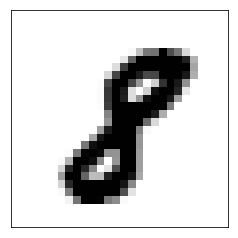

In [24]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow((mnist_raw_3.iloc[1200, :].values).reshape((28,28)), cmap="binary")

### UMAP embedding

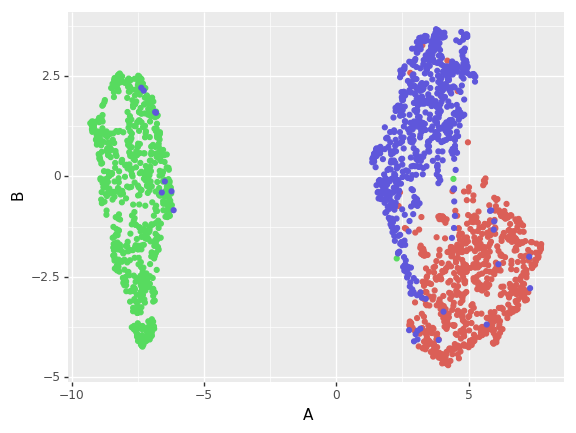

<ggplot: (-9223371890770445820)>

In [25]:
mnist_pca

embedding = umap.UMAP(n_neighbors=10,
                      metric='euclidean').fit_transform(mnist_pca_3)

label = pd.Series(mnist_labels_3)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)

### UMAP embedding + HDBSCAN

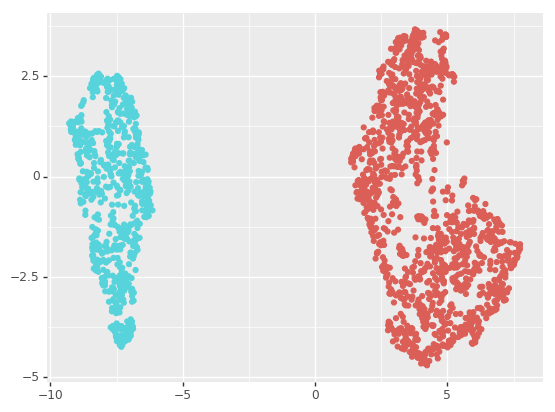

<ggplot: (146031402069)>

In [26]:
import hdbscan

hdbis = hdbscan.HDBSCAN(min_cluster_size=60, min_samples = 10)
hdbis.fit(embedding)
hdbis.labels_
np.unique(hdbis.labels_)
em['hdbs'] = hdbis.labels_.astype(str)
ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+ scale_color_discrete(guide=False) +xlab("")+ylab("")

### K-means

In [ ]:
kmeans = KMeans(n_clusters=3).fit(mnist_pca_3)
em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, kmeans.labels_.astype(str)))
print('ARI: ', metrics.adjusted_rand_score(label, kmeans.labels_.astype(str)))
print('ACU: ', acc(label,  kmeans.labels_.astype(int)))

### GMM-EM

In [ ]:
gmm = GaussianMixture(n_components=3).fit(mnist_pca_3)
labels_gmm = gmm.predict(mnist_pca_3)
em['esti'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='esti'))+geom_point()+ylab("")+xlab("")

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_gmm))
print('ARI: ', metrics.adjusted_rand_score(label, labels_gmm))

In [ ]:
print('ACU: ', acc(label, labels_gmm.astype(int)))

### FREM

In [ ]:
nrep = 1
frem_AMI_3 = np.zeros((nrep, ))
frem_ARI_3 = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(3, mnist_pca_3, 250, False, 1, 20)  
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_3[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_3[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI_3))
print(np.median(frem_ARI_3))
print(np.quantile(frem_AMI_3, 0.25))
print(np.quantile(frem_ARI_3, 0.25))
print(np.quantile(frem_AMI_3, 0.75))
print(np.quantile(frem_ARI_3, 0.75))

In [ ]:
print('ACU: ', acc(label, labels_frem.astype(int)))

In [ ]:
cond_prob = compute_condition_prob_matrix(mnist_pca_3, theta_estimated_1)
labels_cg_3 = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg_3.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated'))+geom_point()

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_cg_3))
print('ARI: ', metrics.adjusted_rand_score(label, labels_cg_3))

### Spectral

In [ ]:
spectral = SpectralClustering(n_clusters = 3, affinity= "nearest_neighbors", n_neighbors=5)
spectral.fit(mnist_pca_3)
print(spectral.labels_)
print('AMI: ', metrics.adjusted_mutual_info_score(label, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(label, spectral.labels_.astype(str)))
print('ACU: ', acc(label, spectral.labels_.astype(int)))

### t-EM

In [ ]:
rlabels = pd.read_csv("labels_frem_MNIST_3.csv").values[:,0]
print('AMI: ', metrics.adjusted_mutual_info_score(label, rlabels))
print('ARI: ', metrics.adjusted_rand_score(label, rlabels))
print('ACU: ', acc(mnist_labels_3, rlabels))

## Introducing some noise

In [27]:
np.random.seed(999)
random.seed(999)

selected_digits_5 = [3, 8, 6]

mnist_pca_5, mnist_labels_5, mnist_raw_5, ve5 = import_subset(mnist_data, mnist_labels_raw, selected_digits_5, 30, 600) 

selected_digits_noise = [0,1,2,4,5,7,9]

mnist_pca_noise, mnist_labels_noise, mnist_raw_noise, ve_noise = import_subset(mnist_data, mnist_labels_raw, selected_digits_noise, 30, 40)
    
mnist_pca_5 = pd.concat((pd.DataFrame(mnist_pca_5), pd.DataFrame(mnist_pca_noise))).values
mnist_labels_5 = np.concatenate((mnist_labels_5, mnist_labels_noise))

In [ ]:
np.savetxt("mnist_pca_5.csv", mnist_pca_5, delimiter=",") # to run in R

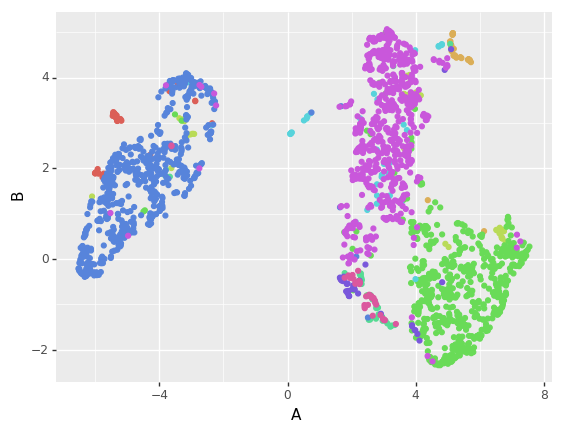

<ggplot: (146029082425)>

In [28]:
embedding = umap.UMAP(n_neighbors=10, min_dist=0.001,
                      metric='euclidean').fit_transform(mnist_pca_5)

label = pd.Series(mnist_labels_5)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)

In [ ]:
mnist_5_not_noise = np.isin(mnist_labels_5.astype(int), [3, 8, 6])

In [ ]:
kmeans = KMeans(n_clusters=3).fit(mnist_pca_5)
em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, kmeans.labels_))
print('ARI: ', metrics.adjusted_rand_score(label, kmeans.labels_))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  kmeans.labels_[mnist_5_not_noise]))

In [ ]:
gmm = GaussianMixture(n_components=3).fit(mnist_pca_5)
labels_gmm = gmm.predict(mnist_pca_5)
em['esti'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='esti'))+geom_point()+ylab("")+xlab("")

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_gmm))
print('ARI: ', metrics.adjusted_rand_score(label, labels_gmm))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  labels_gmm[mnist_5_not_noise]))

In [ ]:
nrep = 1
frem_AMI_5 = np.zeros((nrep, ))
frem_ARI_5 = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(3, mnist_pca_5, 150, False, 1, 20)  
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_5[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_5[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI_5))
print(np.median(frem_ARI_5))
print(np.quantile(frem_AMI_5, 0.25))
print(np.quantile(frem_ARI_5, 0.25))
print(np.quantile(frem_AMI_5, 0.75))
print(np.quantile(frem_ARI_5, 0.75))

In [ ]:
cond_prob = compute_condition_prob_matrix(mnist_pca_5, theta_estimated_1)
labels_cg = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated'))+geom_point()

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(label, labels_frem))
print('ARI: ', metrics.adjusted_rand_score(label, labels_frem))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  labels_frem[mnist_5_not_noise]))

In [ ]:
rlabels = pd.read_csv("labels_frem_MNIST_5.csv").values[:,0]
print('AMI: ', metrics.adjusted_mutual_info_score(label, rlabels))
print('ARI: ', metrics.adjusted_rand_score(label, rlabels))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  rlabels[mnist_5_not_noise]))

In [ ]:
spectral = SpectralClustering(n_clusters = 3, affinity= "nearest_neighbors", n_neighbors=6)
spectral.fit(mnist_pca_5)
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_5, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(mnist_labels_5, spectral.labels_.astype(str)))
print('ACU: ', acc(mnist_labels_5[mnist_5_not_noise],  spectral.labels_[mnist_5_not_noise]))